<a href="https://colab.research.google.com/github/sketchydough/VIbe_style_Matcher/blob/main/Vibe_Matcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
!pip install sentence-transformers openai --quiet
import os
import time

In [ ]:
#dataset->basic fashion items
dataset = [
    {
        "name": "Matcha Oversized Hoodie",
        "desc": "Sage-green oversized hoodie made from soft cotton fleece, perfect for relaxed weekends and coffee runs.",
        "tags": ["cozy", "neutral", "minimal"]
    },
    {
        "name": "Denim Cargo Skirt",
        "desc": "Mid-wash denim skirt with utility pockets and a straight fit, ideal for casual streetwear looks.",
        "tags": ["casual", "retro", "streetwear"]
    },
    {
        "name": "Beige Trench Coat",
        "desc": "Classic beige trench coat with adjustable belt and structured shoulders, designed for everyday city wear.",
        "tags": ["chic", "neutral", "timeless"]
    },
    {
        "name": "Ribbed Knit Co-ord Set",
        "desc": "Two-piece ribbed knit set featuring a cropped sweater and midi skirt, comfortable yet stylish for at-home or casual outings.",
        "tags": ["cozy", "loungewear", "minimal"]
    },
    {
        "name": "Satin Slip Dress",
        "desc": "Champagne satin slip dress with adjustable straps and side slit, perfect for evening dinners and special occasions.",
        "tags": ["feminine", "chic", "nightout"]
    },
    {
        "name": "Canvas Tote Bag",
        "desc": "Neutral canvas tote bag with minimal print, ideal for errands, books, and everyday essentials.",
        "tags": ["casual", "minimal", "functional"]
    },
    {
        "name": "Structured Blazer",
        "desc": "Tailored charcoal blazer with sharp shoulders and inner lining, suitable for work meetings or smart casual events.",
        "tags": ["office", "chic", "modern"]
    },
    {
        "name": "Pastel Knit Cardigan",
        "desc": "Soft pastel knit cardigan with button closure and relaxed fit, great for layering during transitional weather.",
        "tags": ["cozy", "soft", "pastel"]
    },
    {
        "name": "High-Waist Joggers",
        "desc": "Cream high-waist joggers with elastic cuffs and drawstring waist, designed for comfort and daily wear.",
        "tags": ["casual", "comfortcore", "neutral"]
    },
    {
        "name": "Velvet Hair Bow",
        "desc": "Forest-green velvet bow with clip fastening, adds a soft, elegant detail to any outfit.",
        "tags": ["romantic", "accessory", "soft"]
    }
]

df=pd.DataFrame(dataset)

## Note on OpenAI API Usage:

Originally, OpenAI embeddings (text-embedding-ada-002) were intended, however, my personal free credits have been used up, so for demonstration and testing purposes, I am currently using **Sentence Transformers** to generate embeddings.

If you want to run the code with OpenAI embeddings, you can:  
1. Get your own OpenAI API key.  
2. Uncomment & Paste it into the indicated cell below:  

In [ ]:
"""
!pip install openai --quiet
from openai import OpenAI
import os

#Replace "YOUR_API_KEY" with your OpenAI API key
os.environ["OPENAI_API_KEY"]= ""YOUR_API_KEY"

client=OpenAI(api_key=os.environ["OPENAI_API_KEY"])


#Generating Embeddings for description using "text-embedding-ada-002"
def desc_embedding(desc):
    try:
        # converting desc to string just in case if input had any non-string values
        desc = str(desc)
        response = client.embeddings.create( model="text-embedding-ada-002",input=desc)
        return response.data[0].embedding
    except Exception as e:
        print(f"Error embedding: {e}")
        return None


df["embedding"] = df["desc"].apply(desc_embedding)"""

'\n!pip install openai --quiet\nfrom openai import OpenAI\nimport os\n\n#Replace "YOUR_API_KEY" with your OpenAI API key\nos.environ["OPENAI_API_KEY"]= ""YOUR_API_KEY"\n\nclient=OpenAI(api_key=os.environ["OPENAI_API_KEY"])\n\n\n#Generating Embeddings for description using "text-embedding-ada-002"\ndef desc_embedding(desc):\n    try:\n        # converting desc to string just in case if input had any non-string values\n        desc = str(desc)\n        response = client.embeddings.create( model="text-embedding-ada-002",input=desc)\n        return response.data[0].embedding\n    except Exception as e:\n        print(f"Error embedding: {e}")\n        return None\n\n\ndf["embedding"] = df["desc"].apply(desc_embedding)'

##NOTE
Here, I'm writing a combined code in the cell below that uses "sentence transformers by defualt but can switch to "openAI embeddings" if a key is provided. Therefore, its a plug-and-play.

In [ ]:
OPENAI_API_KEY= "" #<-paste your key here to use OpenAi embeddings

sample_query = "energetic urban chic"

#embedding function for description
def desc_embeddings(descs):
    if OPENAI_API_KEY:
        # if opensi key exists -> OpenAI embeddings
        from openai import OpenAI
        client = OpenAI(api_key=OPENAI_API_KEY)
        embeddings = []
        for descriptions in descs:
            response = client.embeddings.create(model="text-embedding-ada-002",input=descriptions)
            embeddings.append(response.data[0].embedding)
        return embeddings
    else:
        # use if openai api key doesn't exist -> Sentence Transformers
        from sentence_transformers import SentenceTransformer
        model = SentenceTransformer('all-MiniLM-L6-v2')
        embeddings = model.encode(descs)
        return embeddings


# Generate embeddings for all descriptions
desc_embeddings_list = desc_embeddings(df['desc'].tolist())
query_embedding = desc_embeddings([sample_query])[0]


print("Embeddings for all descriptions: ", desc_embeddings_list[0][:10])

Embeddings for all descriptions:  [-0.09739627  0.06755719  0.04257635  0.09130127  0.14178918 -0.02062279
  0.0617102   0.02327359 -0.01132031  0.04644825]


In [ ]:
#adding embeddings to the dataframe
df['embeddings']=list(desc_embeddings_list)

# Stack embeddings into a matrix for cosine similarity
stack_emb = np.vstack(df["embeddings"].values)

In [ ]:
#function to find top-3 items for a vibe query

def top_ranked_products(query, top=3, threshold=0.3):
  query_embedding= desc_embeddings([query])[0]
  query_emb_2d = query_embedding.reshape(1, -1)
  sims= cosine_similarity(query_emb_2d, stack_emb)[0]

  df["similarity"]= sims
  df["metric"] = df["similarity"].apply(lambda sim_score: "good" if sim_score >= 0.7 else "poor")

  top_ranked= df.sort_values("similarity", ascending= False).head(top)

  if top_ranked["similarity"].iloc[0] < threshold:
    print(f"\n No good matches found for query: '{sample_query}'. Try describing it in a differnt vibe!")
    return None
  else:
    print(f"\n Top 3 ranked products for query: '{sample_query}':")
    for i,row in top_ranked.iterrows():
      print(f"\n nmae:{row['name']}\nScore: {row['similarity']:.3f}\nDescription: {row['desc']}")
    return top_ranked



 Top 3 ranked products for query: 'energetic urban chic':

 nmae:Pastel Knit Cardigan
Score: 0.428
Description: Soft pastel knit cardigan with button closure and relaxed fit, great for layering during transitional weather.

 nmae:Matcha Oversized Hoodie
Score: 0.366
Description: Sage-green oversized hoodie made from soft cotton fleece, perfect for relaxed weekends and coffee runs.

 nmae:Velvet Hair Bow
Score: 0.362
Description: Forest-green velvet bow with clip fastening, adds a soft, elegant detail to any outfit.

 No good matches found for query: 'energetic urban chic'. Try describing it in a differnt vibe!

 No good matches found for query: 'energetic urban chic'. Try describing it in a differnt vibe!


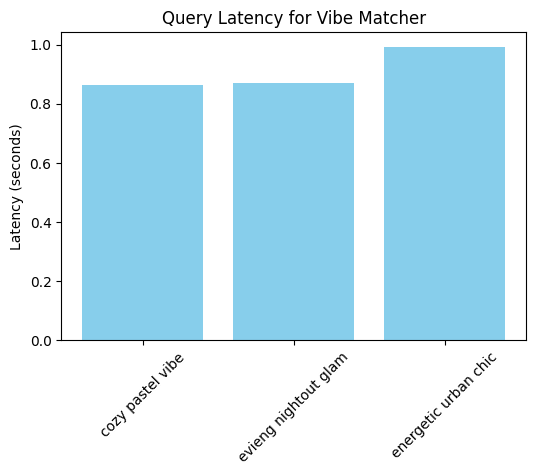

In [ ]:
#Test & evaluating with 3 sample queries

queries=["cozy pastel vibe","evieng nightout glam","energetic urban chic"]

#recording latency for each query
latencies=[]

for q in queries:
  start= time.time()
  top_ranked_products(q)
  end=time.time()
  latencies.append(end-start)

#plotting latency
plt.figure(figsize=(6,4))
plt.bar(range(len(queries)), latencies, color='skyblue')
plt.xticks(range(len(queries)), queries, rotation=45)
plt.ylabel("Latency (seconds)")
plt.title("Query Latency for Vibe Matcher")
plt.show()

#Reflection:
In essence, these improvements move the project from a prototype-level text similarity engine to a production-ready AI-powered fashion recommendation system, capable of understanding user intent, handling large-scale data, and delivering fast, accurate results.

####1.Fine-Tuning with Feedback Loops:
A deep model could be fine-tuned using user interaction data (clicks, likes, or saves). Over time, this would make the system self-improving and capable of learning evolving fashion trends.

####2. Pinecone Integration:
Currently, using cosine similarity, which works for small datasets but becomes inefficient as the product catalog grows. By integrating a vector database such as Pinecone, the model can store and search through thousands of embedding vectors efficiently, supporting real-time recommendations and faster query responses.

####3.Generative AI Layer:
A generative text model could suggest new product descriptions or “vibe tags” dynamically based on current trends, bridging the gap between static catalogs and emerging aesthetic moods.

####4.Deep Neural Retrieval Model:
Instead of only computing static cosine similarity between text embeddings, a Siamese neural network or bi-encoder could be trained on vibe-product pairs to learn a richer similarity function. This would allow the system to adaptively understand complex relationships like “urban chic” vs “grunge streetwear.”

####5.Edge Case Handling:
The system currently returns “No good matches” when similarity scores are low. A better approach is to offer fallback recommendations-for example, showing products with the closest available vibes or prompting the user to refine their query.